In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import requests

In [2]:
url = 'https://www.alphavantage.co/query'
params = {
    'function': 'TIME_SERIES_DAILY',
    'symbol': 'TSLA',
    'outputsize': 'full',
    'apikey': '1SSTSA3XGLWFQLCA'
}

response = requests.get(url, params=params)
# extract the json from the response without the headers and convert it to a dictionary also remove the meta data
data = response.json()['Time Series (Daily)']

In [3]:
# convert the dictionary to a dataframe using
df = pd.read_csv('TSLA.csv')

training_set = df.iloc[:, 1:2].values

print(df.head())

         Date    Open      High       Low   Close     Volume
0  2023-10-16  250.05  255.3999  248.4800  253.92   88917176
1  2023-10-13  258.90  259.6000  250.2200  251.12  102296786
2  2023-10-12  262.92  265.4100  256.6307  258.87  111508114
3  2023-10-11  266.20  268.6000  260.9000  262.99  103706266
4  2023-10-10  257.75  268.9400  257.6500  263.62  122656030


In [4]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler(feature_range=(0,1))

training_set_scaled = sc.fit_transform(training_set)

# print the first 5 rows of the scaled training set
print(training_set_scaled)

[[0.10263802]
 [0.10652134]
 [0.10828529]
 ...
 [0.0038877 ]
 [0.00423435]
 [0.00125495]]


In [5]:
X_train = []
y_train = []
for i in range(60, 3340):
    X_train.append(training_set_scaled[i-60:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

2023-10-17 19:24:42.071172: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-17 19:24:42.318422: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-17 19:24:42.318455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-17 19:24:42.320256: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-17 19:24:42.446310: I tensorflow/core/platform/cpu_feature_g

In [7]:
# Initialising the RNN
regressor = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2))
# Adding a second LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a third LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
# Adding a fourth LSTM layer and some Dropout regularisation
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

2023-10-17 19:24:46.081757: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 19:24:46.107884: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 19:24:46.107989: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 19:24:46.110700: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-17 19:24:46.110732: I tensorflow/compile

Epoch 1/100


2023-10-17 19:24:54.207592: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2023-10-17 19:24:55.146574: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f0cf81db3b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-17 19:24:55.146604: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2023-10-17 19:24:55.156510: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-10-17 19:24:55.240557: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


103/103 [==============================] - 8s 17ms/step - loss: 0.0042
Epoch 2/100
103/103 [==============================] - 2s 17ms/step - loss: 0.0022
Epoch 3/100
103/103 [==============================] - 2s 18ms/step - loss: 0.0017
Epoch 4/100
103/103 [==============================] - 2s 18ms/step - loss: 0.0017
Epoch 5/100
103/103 [==============================] - 2s 20ms/step - loss: 0.0014
Epoch 6/100
103/103 [==============================] - 2s 21ms/step - loss: 0.0013
Epoch 7/100
103/103 [==============================] - 2s 21ms/step - loss: 0.0012
Epoch 8/100
103/103 [==============================] - 2s 21ms/step - loss: 0.0010
Epoch 9/100
103/103 [==============================] - 2s 21ms/step - loss: 0.0011
Epoch 10/100
103/103 [==============================] - 2s 21ms/step - loss: 9.5434e-04
Epoch 11/100
103/103 [==============================] - 2s 21ms/step - loss: 9.7896e-04
Epoch 12/100
103/103 [==============================] - 2s 20ms/step - loss: 7.9187e-04
E

In [36]:
#read only the last 10 days of the stock price
dataset_test = pd.read_csv('TSLAREAL.csv')
real_stock_price = dataset_test.iloc[:, 1:2].values

In [39]:
dataset_total = pd.concat((df['Open'], dataset_test['Open']), axis = 0)
# get the inputs for the test data
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)
X_test = []

for i in range(60, 78):
    X_test.append(inputs[i-60:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)



1/1 [==============================] - 0s 38ms/step


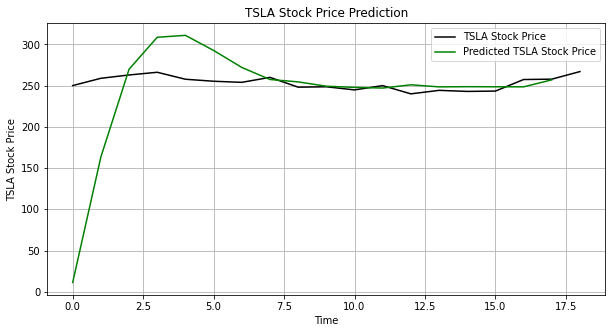

In [40]:
# Visualising the results
plt.plot(real_stock_price, color = 'black', label = 'TSLA Stock Price')
plt.plot(predicted_stock_price, color = 'green', label = 'Predicted TSLA Stock Price')
#make the plot look better
plt.rcParams['figure.figsize'] = [10, 5]
plt.grid(True)
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.legend()
plt.show()

In [24]:
# convert the results to a dataframe
result_df = pd.DataFrame(predicted_stock_price)

#convert the real stock price to a dataframe
real_stock_price_df = pd.DataFrame(real_stock_price)

#calculate the average error of the prediction
error = 0
for i in range(0, len(real_stock_price_df)):
    error += abs(real_stock_price_df.iloc[i,0] - result_df.iloc[i,0])
error = error / len(real_stock_price_df)
print(error)

28.83675332962839
